In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle as pkl
import tensorflow as tf
import metrics

import warnings
warnings.filterwarnings('once')

In [2]:
mape = metrics.build_mape(overlap=6)
smape = metrics.build_smape(overlap=6)
mase_estimate = metrics.build_mase(overlap=6)
owa_estimate = metrics.build_owa(overlap=6)
reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

In [3]:
def MASE(x, y, p):
    nom = np.mean(np.abs(y - p), axis=1)
    denom = np.mean(np.abs(x[:, 1:] - x[:, :-1]), axis=1) + np.finfo('float').eps
    return nom / denom

def SMAPE(y, p):
    nom = np.abs(y - p)
    denom = np.abs(y) + np.abs(p) + np.finfo('float').eps
    return 2 * np.mean(nom / denom, axis=1) * 100

def OWA(x, y, p):
    rel_smape = SMAPE(y, p) / 15.201
    rel_mase = MASE(x, y, p) / 1.685
    return (rel_smape + rel_mase) / 2

In [4]:
train_path = Path('../M4-methods/Dataset/Train/Yearly-train.csv')
test_path = Path('../M4-methods/Dataset/Test/Yearly-test.csv')

In [5]:
train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [6]:
def get_last_12(series):
    return series.dropna().iloc[-12:].values

In [7]:
X_test = np.array([get_last_12(ser[1]) for ser in train.iterrows()])
y_test = test.values

In [8]:
def get_predictions(model, X):
    
    preds = []
    
    for i in range(len(X) // 256):
        x = X[i * 256:(i+1) * 256]

        mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1) 
        x_sc = (x - mn) / (mx - mn)
        pred = model(x_sc[..., np.newaxis]) 
        preds.append(pred[..., 0] * (mx - mn) + mn)

    x = X[(i+1) * 256:]
    mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1) 
    x_sc = (x - mn) / (mx - mn)
    pred = model(x_sc[..., np.newaxis]) 
    preds.append(pred[..., 0] * (mx - mn) + mn)

    return np.vstack(preds)

In [9]:
num_trials = 67
results = {'smape': {k: [] for k in range(num_trials)},
           'mase': {k: [] for k in range(num_trials)},
           'owa': {k: [] for k in range(num_trials)}}

for i in range(num_trials):
    model_dir = 'results/' + str(i) + '/best_weights.h5'

    model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                  'MASE_estimate': mase_estimate,
                                                                  'OWA_estimate': owa_estimate,
                                                                  'reconstruction_loss': reconstruction_loss})
    
    preds = get_predictions(model, X_test)
    
    results['smape'][i].append(np.nanmean(SMAPE(y_test, preds[:, 6:])))
    results['mase'][i].append(np.nanmean(MASE(X_test, y_test, preds[:, 6:])))
    results['owa'][i].append(np.nanmean(OWA(X_test, y_test, preds[:, 6:])))

/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/p

/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/p

In [10]:
results

{'smape': {0: [13.307012008856603],
  1: [13.312890132023561],
  2: [13.412372811814334],
  3: [13.448974783492273],
  4: [13.600577810297244],
  5: [13.462200834565762],
  6: [13.479048722286926],
  7: [13.474238634632872],
  8: [13.436619184876152],
  9: [13.211644733815417],
  10: [13.412307646974234],
  11: [13.341309835606527],
  12: [13.544526150932686],
  13: [13.42191613944829],
  14: [13.55584441425587],
  15: [13.577313984547008],
  16: [13.288620847689229],
  17: [13.473308879904668],
  18: [13.498858812325222],
  19: [13.431355782473911],
  20: [13.485225348845969],
  21: [13.24007036221369],
  22: [13.525727730629205],
  23: [13.434776971088448],
  24: [13.634195508570903],
  25: [13.40024659870089],
  26: [13.682413247205925],
  27: [13.430494286281084],
  28: [13.356475290755085],
  29: [13.366788671204178],
  30: [13.488420235800458],
  31: [13.550911099115558],
  32: [13.577373989292298],
  33: [13.557370795872986],
  34: [13.475417194438092],
  35: [13.354336301197236

In [11]:
def m4_smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.nanmean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()


def m4_mase(insample, y_test, y_hat_test, freq):
    """
    Calculates MAsE
    :param insample: insample data
    :param y_test: out of sample target values
    :param y_hat_test: predicted values
    :param freq: data frequency
    :return:
    """
    y_hat_naive = []
    for i in range(freq, len(insample)):
        y_hat_naive.append(insample[(i - freq)])

    masep = np.mean(abs(insample[freq:] - y_hat_naive))

    return np.nanmean(abs(y_test - y_hat_test)) / masep

In [12]:
m4_smape(y_test, preds[:, 6:])

0.1353691322553586

In [13]:
m4_mase(X_test, y_test, preds[:, 6:], 6)

0.25680578088560957

### fix nan

In [14]:
np.where(np.isnan(preds))

(array([15087, 15087, 15087, 15087, 15087, 15087, 15087, 15087, 15087,
        15087, 15087, 15087]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

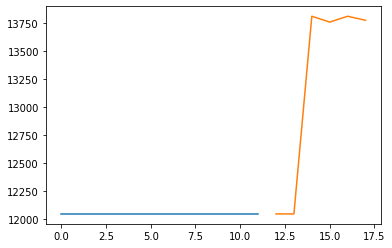

In [15]:
plt.plot(range(12), X_test[15087])
plt.plot(range(12, 18), y_test[15087])

In [16]:
preds_fixed = preds.copy()

In [17]:
preds_fixed[15087] = X_test[15087, -1]

In [18]:
np.any(np.isnan(preds_fixed))

False

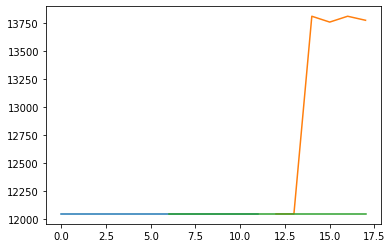

In [19]:
plt.plot(range(12), X_test[15087])
plt.plot(range(12, 18), y_test[15087])
plt.plot(range(6, 18), preds_fixed[15087])

In [20]:
def m4_smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()


def m4_mase(insample, y_test, y_hat_test, freq):
    """
    Calculates MAsE
    :param insample: insample data
    :param y_test: out of sample target values
    :param y_hat_test: predicted values
    :param freq: data frequency
    :return:
    """
    y_hat_naive = []
    for i in range(freq, len(insample)):
        y_hat_naive.append(insample[(i - freq)])

    masep = np.mean(abs(insample[freq:] - y_hat_naive))

    return np.mean(abs(y_test - y_hat_test)) / masep

In [22]:
m4_mase(X_test, y_test, preds_fixed[:, 6:], 6)

0.2568097820044437

### find best

In [26]:
smapes = [s[0] for s in results['smape'].values() if s]
mases = [s[0] for s in results['mase'].values() if s]

In [27]:
np.argmin(smapes)

37

In [28]:
np.argmin(mases)

9

In [31]:
smapes[37], mases[37]

(13.175348506531154, 2.473241526273387)

In [32]:
smapes[9], mases[9]

(13.211644733815417, 2.470802343828664)

In [39]:
model_dir = 'results/37/best_weights.h5'

model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                              'MASE_estimate': mase_estimate,
                                                              'OWA_estimate': owa_estimate,
                                                              'reconstruction_loss': reconstruction_loss})

best_preds = get_predictions(model, X_test)

/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [47]:
best_preds[15087] = X_test[15087, -1]

In [58]:
np.savetxt('m4_predictions.csv', best_preds[:, 6:], delimiter=',')

In [81]:
smapes = [m4_smape(y_test[i], best_preds[i, 6:]) for i in range(len(y_test))]

In [82]:
np.mean(smapes)

0.1317516584416001